In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import SINN_functions as sf
import tensorflow as tf

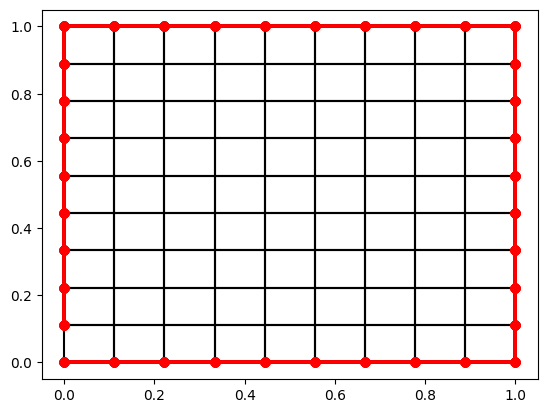

In [71]:
n_grid = 10

# Create nodes
nodes = np.zeros((n_grid*n_grid, 2))
for i in range(n_grid):
    for j in range(n_grid):
        nodes[i + j*n_grid,:] = np.array([i, j])/(n_grid-1)

# Create elements
elements = np.zeros(((n_grid-1)*(n_grid-1), 4), dtype=int)
for i in range(n_grid-1):
    for j in range(n_grid-1):
        elements[i*(n_grid-1) + j,:] = np.array([i*n_grid + j, i*n_grid + j + 1, (i+1)*n_grid + j, (i+1)*n_grid + j + 1])

# Define Boundary nodes
boundary_nodes = np.zeros(4*(n_grid-1), dtype=int)
for i in range(nodes.shape[0]):
    if np.isin([0,1], nodes[i,:]).any():
        boundary_nodes[:n_grid-1] = np.arange(0,n_grid-1)
        boundary_nodes[n_grid-1:2*(n_grid-1)] = np.arange((n_grid-1), n_grid*n_grid-1, n_grid)
        boundary_nodes[2*(n_grid-1):3*(n_grid-1)] = np.arange(n_grid*n_grid-1, (n_grid-1)*n_grid,-1)
        boundary_nodes[3*(n_grid-1):4*(n_grid-1)] = np.arange((n_grid-1)*n_grid, 0, -n_grid)

internal_nodes = np.setdiff1d(np.arange(nodes.shape[0]), boundary_nodes)

# Plotting the mesh
for el in elements:
    plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    plt.plot(nodes[boundary_nodes,0], nodes[boundary_nodes,1], '-o', color='r')


In [79]:
K_el = np.array([[  2/3,   1/3,  -1/6, -1/12,  -1/6, -1/12,  -1/3,  -1/6],
[  1/3,   2/3, -1/12,  -1/6, -1/12,  -1/6,  -1/6,  -1/3],
[ -1/6, -1/12,   2/3,   1/3,  -1/3,  -1/6,  -1/6, -1/12],
[-1/12,  -1/6,   1/3,   2/3,  -1/6,  -1/3, -1/12,  -1/6],
[ -1/6, -1/12,  -1/3,  -1/6,   2/3,   1/3,  -1/6, -1/12],
[-1/12,  -1/6,  -1/6,  -1/3,   1/3,   2/3, -1/12,  -1/6],
[ -1/3,  -1/6,  -1/6, -1/12,  -1/6, -1/12,   2/3,   1/3],
[ -1/6,  -1/3, -1/12,  -1/6, -1/12,  -1/6,   1/3,   2/3]])

r = int(K_el.shape[0]/4)

# Assemble the global stiffness matrix
K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
for el in elements:
    el_idx = [[2*i,2*i+1] for i in el]
    el_idx = np.concatenate(el_idx)
    X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
    K[Y_idx,X_idx] += K_el

# Define Dirichlet BC
BCfunc = lambda alpha: np.array([np.sin(alpha), np.cos(alpha)]).T
x_BC = nodes[boundary_nodes,0]
y_BC = nodes[boundary_nodes,1]
alpha = np.arctan2(y_BC-0.5,x_BC-0.5)
l_BC = BCfunc(alpha)

# # Apply Dirichlet BC
bc_idx = [[2*i,2*i+1] for i in boundary_nodes]
bc_idx = np.concatenate(bc_idx)
internal_idx = [[2*i,2*i+1] for i in internal_nodes]
internal_idx = np.concatenate(internal_idx)

f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

K_BC = K[internal_idx,:][:,internal_idx]
f = f[internal_idx]

# Solve the system
l_internal = np.linalg.solve(K_BC, f)
n_CDOF = int(l_internal.shape[0]/r)
l_internal = l_internal.reshape(n_CDOF, r)

l = np.zeros((nodes.shape[0], r))
l[internal_nodes,:] = l_internal
l[boundary_nodes,:] = l_BC.reshape(-1,2)

In [83]:
X,Y = np.meshgrid(np.linspace(0,1,11), np.linspace(0,1,11))
xi = np.array([X.flatten(), Y.flatten()]).T

l_grid = interpolate.griddata(nodes, l, xi, method='cubic')
l_grid = l_grid.reshape(11,11,2)

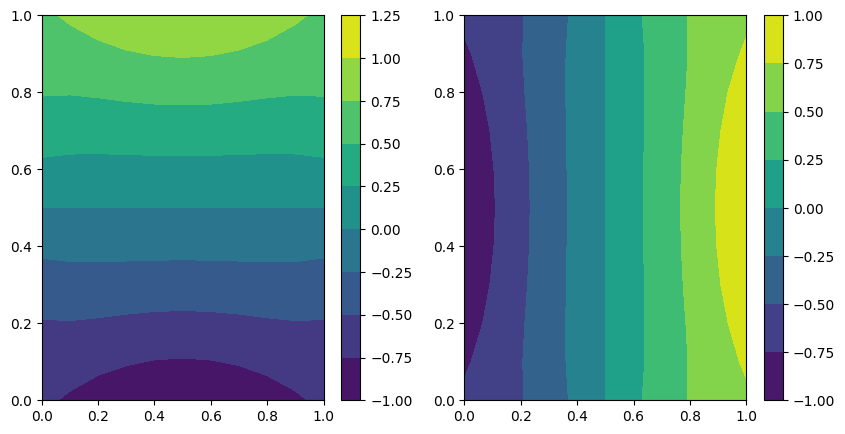

In [86]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(X,Y,l_grid[:,:,0])
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(X,Y,l_grid[:,:,1])
plt.colorbar()

In [122]:
C = np.zeros((2,2,6))
C[:,:,3] = np.array([[1,0.5],[0.5,1]])
C[:,:,4] = np.array([[1,0.5],[0.5,1]])

u_bc = np.zeros((X.shape[0],X.shape[1],2))
alpha = np.arctan2(Y-0.5,X-0.5)
u_bc[:,:,0] = np.sin(alpha)
u_bc[:,:,1] = np.cos(alpha)
u_bc[1:-1,1:-1,:] = 0
u_bc = np.moveaxis(u_bc, -1, 0)

u = sf.SolveProblem(C,u_bc,Y,X)
u = np.moveaxis(u, 0, -1)

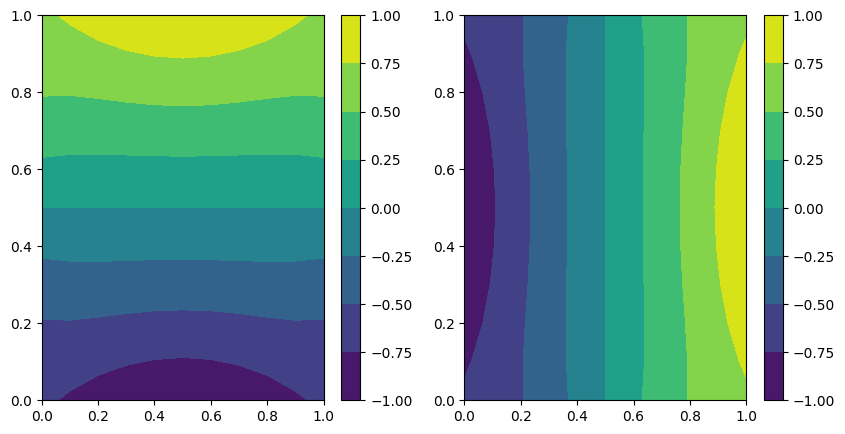

In [123]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(X,Y,u[:,:,0])
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(X,Y,u[:,:,1])
plt.colorbar()

In [233]:
# FEM with variable grid -> K_el calculation
# K_el = int(int(B.T @ A @ B * det(J),d_xi),d_eta)

# B precalculation
def GetB_xi_eta(r):
    # Constructs the function B(xi,eta) for a given r

    def f(xi,eta):
        N1_xi = (eta-1)/4
        N2_xi = (1-eta)/4
        N3_xi = -(1+eta)/4
        N4_xi = (1+eta)/4

        N1_eta = (xi-1)/4
        N2_eta = -(1+xi)/4
        N3_eta = (1-xi)/4
        N4_eta = (1+xi)/4

        B = np.concatenate([
            np.concatenate([N1_xi*np.eye(r), N2_xi*np.eye(r), N3_xi*np.eye(r), N4_xi*np.eye(r)], axis=1),
            np.concatenate([N1_eta*np.eye(r), N2_eta*np.eye(r), N3_eta*np.eye(r), N4_eta*np.eye(r)], axis=1)
        ], axis=0)
        return B
    return f

# Precalculate Gauss points and weights
def GetGaussPoints(n_gauss):
    xi = np.zeros((n_gauss,n_gauss))
    eta = np.zeros((n_gauss,n_gauss))
    weight = np.zeros((n_gauss,n_gauss))
    if n_gauss == 1:
        xi[0,0] = 0
        eta[0,0] = 0
        weight[0,0] = 4
    elif n_gauss == 2:
        for i in range(2):
            for j in range(2):
                xi[i,j] = -np.sqrt(1/3)*(-1)**i
                eta[i,j] = -np.sqrt(1/3)*(-1)**j
                weight[i,j] = 1
    else:
        raise ValueError(f'Gauss points not supported for n_gauss = {n_gauss}')
    return xi, eta, weight

# Precalculate B for numerical integration
def GetB(r,xi,eta):
    # r = number of latent variables
    # n_gauss = number of gauss points for numerical integration
    
    B_xi_eta = GetB_xi_eta(r)
    B = np.zeros((n_gauss,n_gauss,r*2, r*4))
    for i,xi in enumerate(xi_arr):
        for j,eta in enumerate(eta_arr):
            B[i,j,:,:] = B_xi_eta(xi,eta)
    return B

B = GetB(2,2)

# Define general function for |J(xi,eta)| - Determinant of the Jacobian matrix
def GetM_J(nodes):
    # M_J is defined such that det(J(xi,eta)) = M_J @ [1, eta, xi]
    # nodes = [[x1,y1],[x2,y2],...]
    M_J = tf.concat([
        tf.reshape(nodes[0,0]*nodes[1,1] - nodes[1,0]*nodes[0,1] + nodes[2,0]*nodes[0,1] - nodes[0,0]*nodes[2,1] + \
         nodes[1,0]*nodes[3,1] - nodes[3,0]*nodes[1,1] + nodes[3,0]*nodes[2,1] - nodes[2,0]*nodes[3,1],(1,1)),
        tf.reshape(nodes[1,0]*nodes[0,1] - nodes[0,0]*nodes[1,1] + nodes[0,0]*nodes[3,1] - nodes[3,0]*nodes[0,1] + \
         nodes[2,0]*nodes[1,1] - nodes[1,0]*nodes[2,1] + nodes[3,0]*nodes[2,1] - nodes[2,0]*nodes[3,1],(1,1)),
        tf.reshape(nodes[0,0]*nodes[2,1] - nodes[2,0]*nodes[0,1] + nodes[3,0]*nodes[0,1] - nodes[0,0]*nodes[3,1] + \
         nodes[2,0]*nodes[1,1] - nodes[1,0]*nodes[2,1] + nodes[1,0]*nodes[3,1] - nodes[3,0]*nodes[1,1],(1,1))
    ],axis=1)/8
    return M_J

# Define general function for K_el using gaussian integrations
def GetK_el(B,A,M_J):
    K_partial = np.matmul(np.transpose(B,(0,1,3,2)) , np.matmul(A,B))*J

nodes = tf.constant([[0,0],[1,0],[0,1],[1,1]],tf.float32)
M_J = GetM_J(nodes)


In [214]:
A11 = np.array([[1,0.5],[0.5,1]])
A12 = np.array([[0,0],[0,0]])
A22 = np.array([[1,0.5],[0.5,1]])
A = np.concatenate([
    np.concatenate([A11,A12],axis=1),
    np.concatenate([A12,A22],axis=1)
],axis=0)
A

array([[1. , 0.5, 0. , 0. ],
       [0.5, 1. , 0. , 0. ],
       [0. , 0. , 1. , 0.5],
       [0. , 0. , 0.5, 1. ]])

In [221]:
p = np.matmul(np.transpose(B,(0,1,3,2)) , np.matmul(A,B))

In [226]:
GausP = np.zeros((2,2,1,3))
for i in range(2):
    for j in range(2):
        GausP[i,j,:,:] = [[1],[(j*2-1)/np.sqrt(3)],[(i*2-1)/np.sqrt(3)]]

In [234]:
M_J @ GausP

<tf.Tensor: shape=(2, 2, 1, 1), dtype=float32, numpy=
array([[[[0.25]],

        [[0.25]]],


       [[[0.25]],

        [[0.25]]]], dtype=float32)>

In [209]:
p = np.matmul(np.transpose(B,(0,1,3,2)),B)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 4)